In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import Pool,CatBoostClassifier

pd.reset_option
pd.set_option('display.max_columns',None)

In [2]:
train=pd.read_csv('Jobcare_data/train.csv')
test=pd.read_csv('Jobcare_data/test.csv')
submission=pd.read_csv('Jobcare_data/sample_submission.csv')

In [3]:
train

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [15]:
D_code=pd.read_csv('Jobcare_data/속성_D_코드.csv')
H_code=pd.read_csv('Jobcare_data/속성_H_코드.csv')
L_code=pd.read_csv('Jobcare_data/속성_L_코드.csv')

In [9]:
D_code

,속성 D 코드,속성 D 세분류코드,속성 D 소분류코드,속성 D 중분류코드,속성 D 대분류코드
0,4,4,3,2,1
1,5,5,3,2,1
2,7,7,6,2,1
3,8,8,6,2,1
4,9,8,6,2,1
...,...,...,...,...,...
1109,1254,1254,1254,1235,1235
1110,1255,1254,1254,1235,1235
1111,1256,1254,1254,1235,1235
1112,1257,1254,1254,1235,1235


In [10]:
H_code

,속성 H 코드,속성 H 중분류코드,속성 H 대분류코드
0,2,315,1
1,4,316,3
2,5,317,3
3,6,318,3
4,7,319,3
...,...,...,...
289,309,566,308
290,310,567,308
291,311,568,308
292,313,569,312


In [11]:
L_code

,속성 L 코드,속성 L 세분류코드,속성 L 소분류코드,속성 L 중분류코드,속성 L 대분류코드
0,1,1,1,1,2004
1,2,2,2,1,2004
2,3,3,2,1,2004
3,4,3,2,1,2004
4,5,5,2,1,2004
...,...,...,...,...,...
2020,2021,2021,2021,2021,2021
2021,2022,2022,2022,2022,2022
2022,2023,2023,2023,2023,2023
2023,2024,2024,2024,2024,2024


## 속성코드 매칭

In [3]:
from typing import Dict

def add_code(
    df: pd.DataFrame,
    d_code: Dict[int, Dict[str, int]], 
    h_code: Dict[int, Dict[str, int]], 
    l_code: Dict[int, Dict[str, int]],
) -> pd.DataFrame:
    
    # Copy input data
    df = df.copy()   

    # D Code
    df['person_prefer_d_1_n'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_1_s'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_1_m'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_1_l'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_2_n'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_2_s'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_2_m'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_2_l'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_3_n'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_3_s'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_3_m'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_3_l'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['contents_attribute_d_n'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['contents_attribute_d_s'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['contents_attribute_d_m'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['contents_attribute_d_l'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    # H Code
    df['person_prefer_h_1_l'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_1_m'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_2_l'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_2_m'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_3_l'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_3_m'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['contents_attribute_h_l'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['contents_attribute_h_m'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    # L Code
    df['contents_attribute_l_n'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 세분류코드'])
    df['contents_attribute_l_s'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 소분류코드'])
    df['contents_attribute_l_m'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 중분류코드'])
    df['contents_attribute_l_l'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 대분류코드'])
    
    return df

In [4]:
D_code=pd.read_csv('Jobcare_data/속성_D_코드.csv',index_col=0).T.to_dict()
H_code=pd.read_csv('Jobcare_data/속성_H_코드.csv',index_col=0).T.to_dict()
L_code=pd.read_csv('Jobcare_data/속성_L_코드.csv',index_col=0).T.to_dict()

train2=add_code(train,D_code,H_code,L_code)
test2=add_code(test,D_code,H_code,L_code)

In [20]:
train2.to_csv('df_train.csv',index=False)

## EDA

In [32]:
train2.isna().sum()

id                        0
d_l_match_yn              0
d_m_match_yn              0
d_s_match_yn              0
h_l_match_yn              0
                         ..
contents_attribute_h_m    0
contents_attribute_l_n    0
contents_attribute_l_s    0
contents_attribute_l_m    0
contents_attribute_l_l    0
Length: 63, dtype: int64

0    251106
1    250845
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

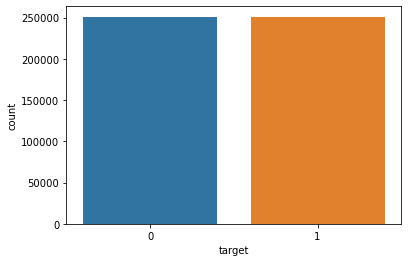

In [26]:
#컨텐츠 사용 여부
print(train2['target'].value_counts())
sns.countplot(data=train2, x='target')

1    331260
2    170691
Name: person_attribute_a, dtype: int64


<AxesSubplot:xlabel='person_attribute_a', ylabel='count'>

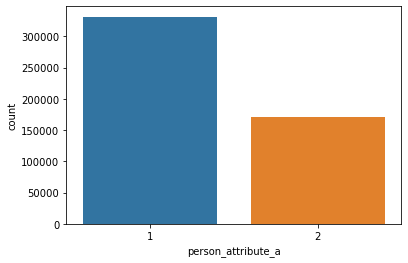

In [29]:
#회원 속성 A
print(train2['person_attribute_a'].value_counts())
sns.countplot(data=train2, x='person_attribute_a')

0    158626
1     61195
5     57783
2     51895
6     49820
3     46340
4     44325
7     31967
Name: person_attribute_a_1, dtype: int64


<AxesSubplot:xlabel='person_attribute_a_1', ylabel='count'>

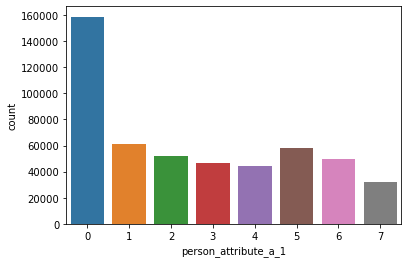

In [33]:
#회원 속성 A 하위 속성 1(순서형)
print(train2['person_attribute_a_1'].value_counts())
sns.countplot(data=train2, x='person_attribute_a_1')

2    223884
3    139489
4    121200
1     10150
5      7123
0       105
Name: person_attribute_b, dtype: int64


<AxesSubplot:xlabel='person_attribute_b', ylabel='count'>

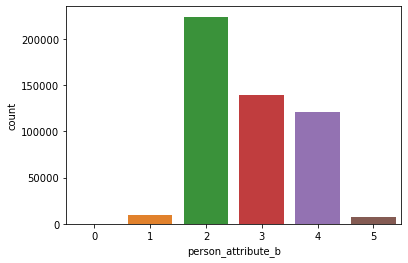

In [34]:
#회원 속성 B (순서형)
print(train2['person_attribute_b'].value_counts())
sns.countplot(data=train2, x='person_attribute_b') #0이 매우 적음

1    304571
5    156688
2     20223
3     15665
4      4804
Name: person_prefer_c, dtype: int64


<AxesSubplot:xlabel='person_prefer_c', ylabel='count'>

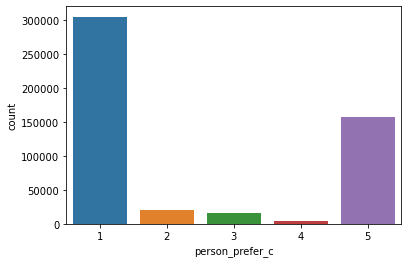

In [35]:
#회원 선호 속성 C
print(train2['person_prefer_c'].value_counts())
sns.countplot(data=train2, x='person_prefer_c')

4     160100
3     139683
5      81635
0      66676
6      31407
7       8641
8       6259
2       2323
10      1936
9       1473
11      1452
1        366
Name: person_prefer_e, dtype: int64


<AxesSubplot:xlabel='person_prefer_e', ylabel='count'>

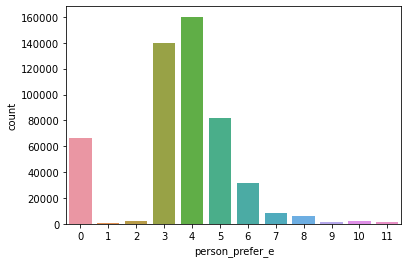

In [38]:
#회원 선호 속성 E (순서형)
print(train2['person_prefer_e'].value_counts())
sns.countplot(data=train2, x='person_prefer_e')

1    501951
Name: person_prefer_f, dtype: int64


<AxesSubplot:xlabel='person_prefer_f', ylabel='count'>

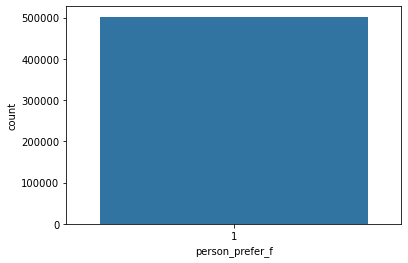

In [40]:
#회원 선호 속성 F
print(train2['person_prefer_f'].value_counts())
sns.countplot(data=train2, x='person_prefer_f') #모두 1임.

1    46404
Name: person_prefer_f, dtype: int64


<AxesSubplot:xlabel='person_prefer_f', ylabel='count'>

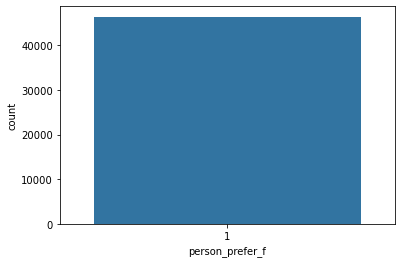

In [48]:
#회원 선호 속성 F - 테스트
print(test['person_prefer_f'].value_counts())
sns.countplot(data=test, x='person_prefer_f') #모두 1임. 나중에 제외

1    501951
Name: person_prefer_g, dtype: int64


<AxesSubplot:xlabel='person_prefer_g', ylabel='count'>

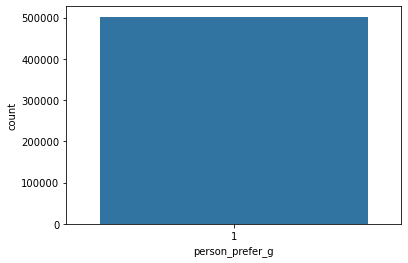

In [41]:
#회원 선호 속성 G
print(train2['person_prefer_g'].value_counts())
sns.countplot(data=train2, x='person_prefer_g') #모두 1임.

1    46404
Name: person_prefer_g, dtype: int64


<AxesSubplot:xlabel='person_prefer_g', ylabel='count'>

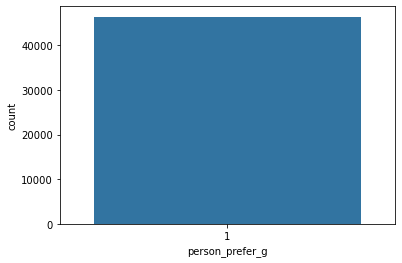

In [47]:
#회원 선호 속성 G - 테스트
print(test['person_prefer_g'].value_counts())
sns.countplot(data=test, x='person_prefer_g') #모두 1임. 나중에 제외

3    341052
1    116273
2     44626
Name: contents_attribute_i, dtype: int64


<AxesSubplot:xlabel='contents_attribute_i', ylabel='count'>

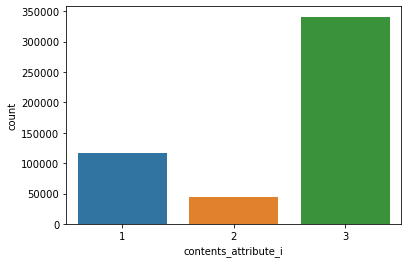

In [42]:
#컨텐츠 속성I
print(train2['contents_attribute_i'].value_counts())
sns.countplot(data=train2, x='contents_attribute_i')

3    308855
1    141895
2     51201
Name: contents_attribute_a, dtype: int64


<AxesSubplot:xlabel='contents_attribute_a', ylabel='count'>

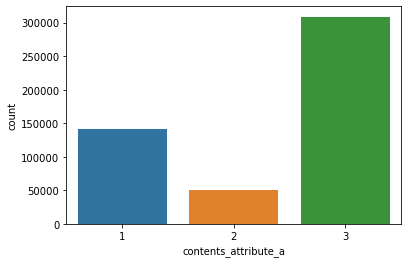

In [43]:
#컨텐츠 속성A
print(train2['contents_attribute_a'].value_counts())
sns.countplot(data=train2, x='contents_attribute_a') #i랑 a랑 비슷해보임

1    382584
2    119367
Name: contents_attribute_j, dtype: int64


<AxesSubplot:xlabel='contents_attribute_j', ylabel='count'>

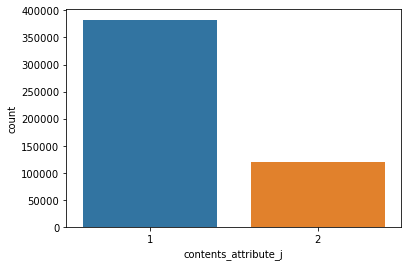

In [44]:
#컨텐츠 속성J
print(train2['contents_attribute_j'].value_counts())
sns.countplot(data=train2, x='contents_attribute_j')

5     330790
10     89307
3      30664
4      19649
9      19115
6      10808
2       1416
8        137
1         65
Name: contents_attribute_j_1, dtype: int64


<AxesSubplot:xlabel='contents_attribute_j_1', ylabel='count'>

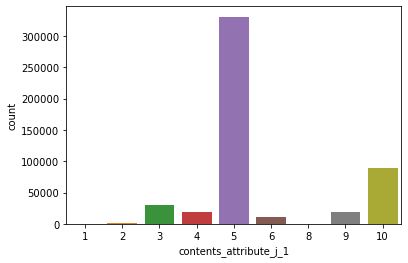

In [45]:
#컨텐츠 속성J 하위속성1
print(train2['contents_attribute_j_1'].value_counts())
sns.countplot(data=train2, x='contents_attribute_j_1') #7이 없음

5     30092
10     7910
3      3281
9      2143
4      1772
6      1057
2       120
8        24
1         5
Name: contents_attribute_j_1, dtype: int64


<AxesSubplot:xlabel='contents_attribute_j_1', ylabel='count'>

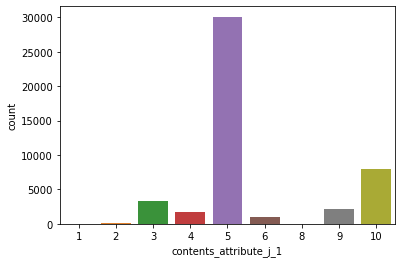

In [46]:
#컨텐츠 속성J 하위속성1 - 테스트 데이터
print(test['contents_attribute_j_1'].value_counts())
sns.countplot(data=test, x='contents_attribute_j_1') #7이 없음

1    401409
3     82929
2     12459
4      5154
Name: contents_attribute_c, dtype: int64


<AxesSubplot:xlabel='contents_attribute_c', ylabel='count'>

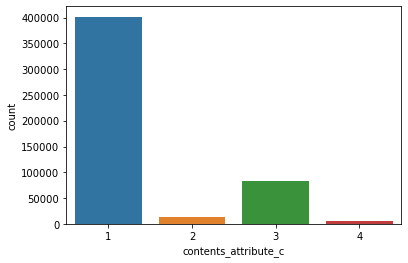

In [49]:
#컨텐츠 속성C
print(train2['contents_attribute_c'].value_counts())
sns.countplot(data=train2, x='contents_attribute_c') #5가 없음

1    34923
3     9644
2     1202
4      635
Name: contents_attribute_c, dtype: int64


<AxesSubplot:xlabel='contents_attribute_c', ylabel='count'>

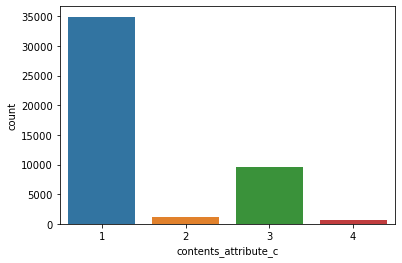

In [50]:
#컨텐츠 속성C - 테스트
print(test['contents_attribute_c'].value_counts())
sns.countplot(data=test, x='contents_attribute_c') #5가 없음

2    483533
1     18418
Name: contents_attribute_k, dtype: int64


<AxesSubplot:xlabel='contents_attribute_k', ylabel='count'>

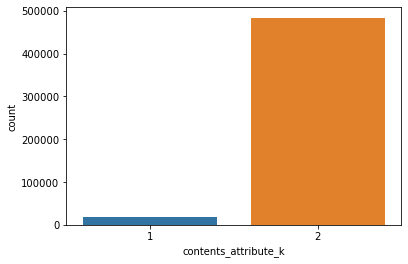

In [51]:
#컨텐츠 속성K
print(train2['contents_attribute_k'].value_counts())
sns.countplot(data=train2, x='contents_attribute_k')

1    272885
4     86367
5     67639
2     57114
3     17946
Name: contents_attribute_m, dtype: int64


<AxesSubplot:xlabel='contents_attribute_m', ylabel='count'>

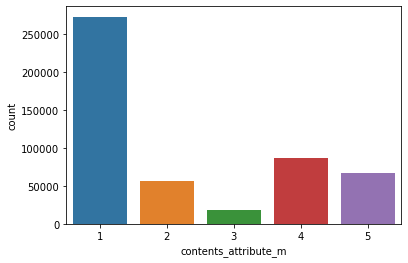

In [52]:
#컨텐츠 속성M
print(train2['contents_attribute_m'].value_counts())
sns.countplot(data=train2, x='contents_attribute_m')

3     187593
4     175628
5      81684
6      27776
2       9414
7       7734
1       5179
8       3991
0       1025
9        908
10       673
11       346
Name: contents_attribute_e, dtype: int64


<AxesSubplot:xlabel='contents_attribute_e', ylabel='count'>

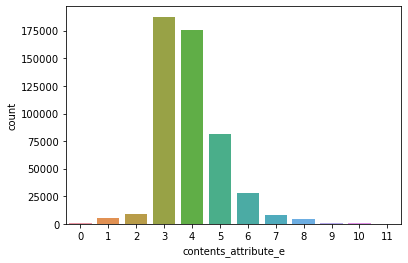

In [53]:
#컨텐츠 속성E (순서형)
print(train2['contents_attribute_e'].value_counts())
sns.countplot(data=train2, x='contents_attribute_e')

<AxesSubplot:xlabel='person_attribute_a', ylabel='target'>

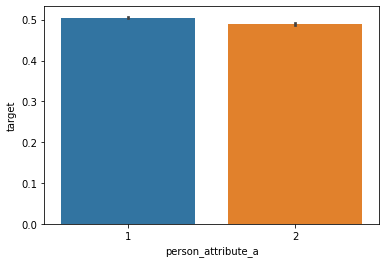

In [12]:
#회원속성 A와 컨텐츠 사용 여부
sns.barplot(data=train2,x='person_attribute_a',y='target')

<AxesSubplot:xlabel='person_attribute_a_1', ylabel='target'>

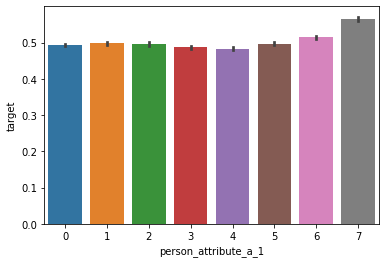

In [10]:
sns.barplot(data=train2,x='person_attribute_a_1',y='target')

<AxesSubplot:xlabel='person_attribute_b', ylabel='target'>

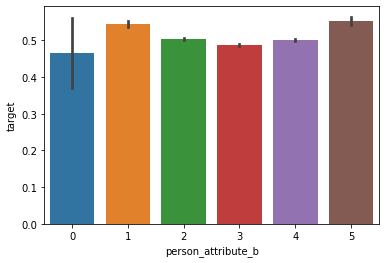

In [13]:
sns.barplot(data=train2,x='person_attribute_b',y='target')

<AxesSubplot:xlabel='person_prefer_c', ylabel='target'>

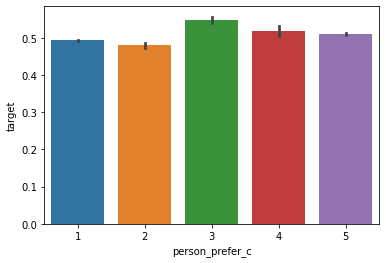

In [15]:
sns.barplot(data=train2,x='person_prefer_c',y='target')

<AxesSubplot:xlabel='person_prefer_e', ylabel='target'>

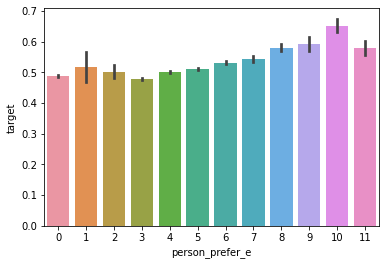

In [16]:
sns.barplot(data=train2,x='person_prefer_e',y='target')

<AxesSubplot:xlabel='contents_attribute_i', ylabel='target'>

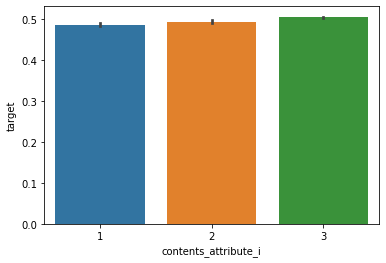

In [17]:
sns.barplot(data=train2,x='contents_attribute_i',y='target')

<AxesSubplot:xlabel='contents_attribute_a', ylabel='target'>

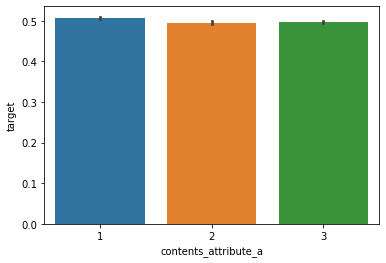

In [18]:
sns.barplot(data=train2,x='contents_attribute_a',y='target')

<AxesSubplot:xlabel='contents_attribute_j', ylabel='target'>

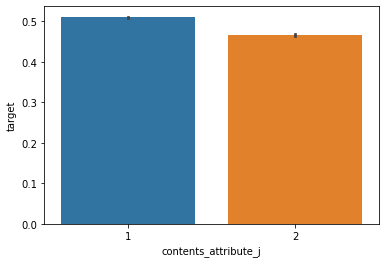

In [20]:
sns.barplot(data=train2,x='contents_attribute_j',y='target')

<AxesSubplot:xlabel='contents_attribute_j_1', ylabel='target'>

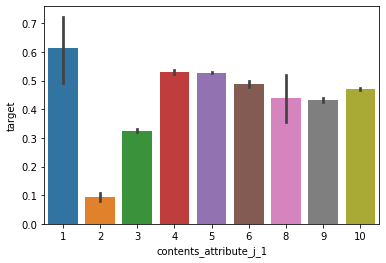

In [21]:
sns.barplot(data=train2,x='contents_attribute_j_1',y='target') #컨텐츠속성 j 하위속성이 2일 때 0인 경우가 약 90?%

<AxesSubplot:xlabel='contents_attribute_c', ylabel='target'>

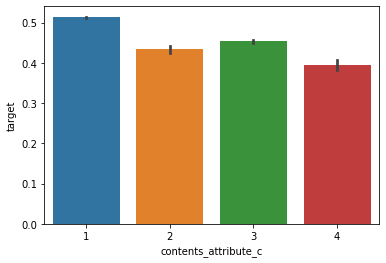

In [22]:
sns.barplot(data=train2,x='contents_attribute_c',y='target')

<AxesSubplot:xlabel='contents_attribute_k', ylabel='target'>

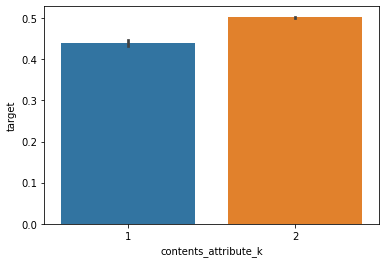

In [23]:
sns.barplot(data=train2,x='contents_attribute_k',y='target')

<AxesSubplot:xlabel='contents_attribute_m', ylabel='target'>

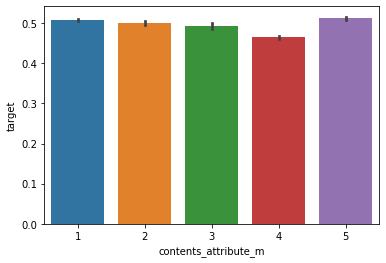

In [24]:
sns.barplot(data=train2,x='contents_attribute_m',y='target')

<AxesSubplot:xlabel='contents_attribute_e', ylabel='target'>

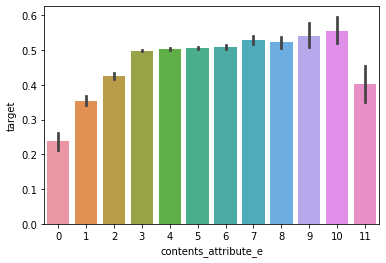

In [25]:
sns.barplot(data=train2,x='contents_attribute_e',y='target')

In [7]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    phi2 = stat / obs
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs - 1)))
    rcorr = r - ((r-1)**2)/(obs-1)
    kcorr = k - ((k-1)**2)/(obs-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [9]:
train3=train.drop(['id','person_rn','contents_rn','contents_open_dt','person_prefer_f','person_prefer_g'], axis=1)

In [ ]:
rows= []

for var1 in train3:
  col = []
  for var2 in train3 :
    cramers =cramers_V(train3[var1], train3[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = train3.columns, index =train3.columns)

In [15]:
df
#컨텐츠속성L과 컨텐츠속성J 하위속성: 0.51, 컨텐츠속성J와 컨텐츠속성 J 하위속성: 1, d_m_match_yn과 d_s_match_yn : 0.70
#h_l_match_yn과 person_prefer_h_1 : 0.50, h_m_match_yn과 h_s_match_yn : 0.81, person_prefer_h_1과 h_s_match_yn : 0.68
#person_attribute_a와 person_attribute_a_1 : 0.86, person_prefer_d_1과 person_prefer_d_3 : 0.50, h_m_match_yn과 person_prefer_h_1 : 0.67
#h_m_match_yn와 person_prefer_h_3 : 0.50

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,target
d_l_match_yn,1.00,0.46,0.32,0.01,0.02,0.02,0.06,0.04,0.03,0.04,0.33,0.25,0.27,0.05,0.10,0.09,0.08,0.02,0.08,0.06,0.01,0.06,0.02,0.17,0.39,0.05,0.07,0.11,0.14
d_m_match_yn,0.46,1.00,0.70,0.06,0.07,0.06,0.08,0.06,0.02,0.02,0.38,0.26,0.29,0.10,0.11,0.10,0.09,0.01,0.14,0.09,0.04,0.02,0.01,0.18,0.38,0.02,0.06,0.11,0.12
d_s_match_yn,0.32,0.70,1.00,0.07,0.06,0.05,0.06,0.04,0.02,0.01,0.35,0.24,0.26,0.09,0.09,0.08,0.07,0.00,0.09,0.09,0.05,0.01,0.00,0.14,0.36,0.02,0.05,0.08,0.09
h_l_match_yn,0.01,0.06,0.07,1.00,0.38,0.31,0.03,0.10,0.08,0.04,0.27,0.24,0.24,0.21,0.50,0.37,0.38,0.02,0.07,0.05,0.04,0.03,0.00,0.12,0.23,0.07,0.19,0.24,0.02
h_m_match_yn,0.02,0.07,0.06,0.38,1.00,0.81,0.02,0.08,0.11,0.05,0.24,0.22,0.22,0.17,0.67,0.44,0.50,0.00,0.06,0.04,0.04,0.03,0.01,0.15,0.20,0.07,0.13,0.49,0.00
h_s_match_yn,0.02,0.06,0.05,0.31,0.81,1.00,0.01,0.07,0.11,0.05,0.22,0.20,0.20,0.14,0.68,0.43,0.45,0.01,0.06,0.03,0.03,0.03,0.01,0.14,0.18,0.07,0.11,0.44,0.01
person_attribute_a,0.06,0.08,0.06,0.03,0.02,0.01,1.00,0.86,0.04,0.05,0.30,0.21,0.22,0.23,0.12,0.12,0.10,0.01,0.18,0.06,0.03,0.01,0.00,0.11,0.16,0.03,0.12,0.11,0.02
person_attribute_a_1,0.04,0.06,0.04,0.10,0.08,0.07,0.86,1.00,0.04,0.04,0.17,0.15,0.15,0.14,0.08,0.08,0.07,0.01,0.14,0.03,0.04,0.02,0.01,0.06,0.10,0.02,0.07,0.06,0.04
person_attribute_b,0.03,0.02,0.02,0.08,0.11,0.11,0.04,0.04,1.00,0.04,0.26,0.25,0.23,0.06,0.12,0.10,0.10,0.01,0.04,0.05,0.03,0.02,0.01,0.10,0.18,0.05,0.04,0.09,0.02
person_prefer_c,0.04,0.02,0.01,0.04,0.05,0.05,0.05,0.04,0.04,1.00,0.16,0.14,0.14,0.08,0.08,0.07,0.07,0.02,0.02,0.04,0.03,0.06,0.02,0.08,0.10,0.04,0.05,0.06,0.02


## 데이터 전처리 & EDA

In [5]:
#컨텐츠 열람 시간 - 시간대 추출
train2['contents_open_dt2']=pd.to_datetime(train2['contents_open_dt'])
train2['contents_open_hour']=train2['contents_open_dt2'].dt.hour
train2['contents_open_hour']

0         12
1         17
2         20
3         18
4         20
          ..
501946    12
501947    11
501948    17
501949     9
501950    14
Name: contents_open_hour, Length: 501951, dtype: int64

In [6]:
test2['contents_open_dt2']=pd.to_datetime(test2['contents_open_dt'])
test2['contents_open_hour']=test2['contents_open_dt2'].dt.hour
test2['contents_open_hour']

0         2
1         5
2        23
3        19
4        21
         ..
46399     1
46400    21
46401    19
46402    14
46403    16
Name: contents_open_hour, Length: 46404, dtype: int64

15    37581
16    36621
14    36206
11    34883
12    33216
13    33126
17    33116
10    31445
18    26177
20    23716
21    23381
19    23110
9     21908
22    21660
23    18230
0     14147
8     12751
1      9931
7      8312
2      6426
6      4859
3      4446
5      3356
4      3347
Name: contents_open_hour, dtype: int64


<AxesSubplot:xlabel='contents_open_hour', ylabel='count'>

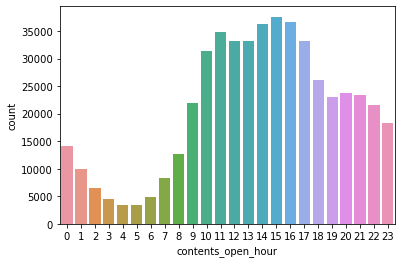

In [6]:
print(train2['contents_open_hour'].value_counts())
sns.countplot(data=train2, x='contents_open_hour')

<AxesSubplot:xlabel='contents_open_hour', ylabel='target'>

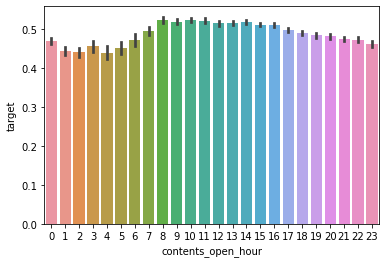

In [9]:
sns.barplot(data=train2,x='contents_open_hour',y='target')

In [7]:
#컨텐츠 열람 시간 - 요일 추출
train2['contents_open_weekday']=train2['contents_open_dt2'].dt.weekday
train2['contents_open_weekday'] #월요일:0, 일요일:6

0         4
1         3
2         2
3         0
4         0
         ..
501946    4
501947    0
501948    2
501949    0
501950    0
Name: contents_open_weekday, Length: 501951, dtype: int64

In [8]:
test2['contents_open_weekday']=test2['contents_open_dt2'].dt.weekday

0    100270
1     95062
2     88915
3     85298
4     71155
6     31205
5     30046
Name: contents_open_weekday, dtype: int64


<AxesSubplot:xlabel='contents_open_weekday', ylabel='count'>

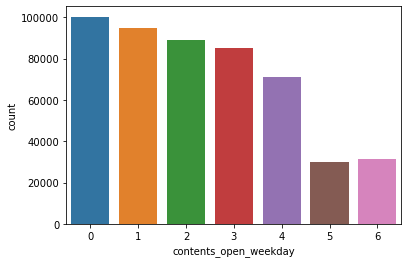

In [10]:
print(train2['contents_open_weekday'].value_counts())
sns.countplot(data=train2, x='contents_open_weekday') #주말은 평일에 비해 컨텐츠 이용 건수가 떨어짐

<AxesSubplot:xlabel='contents_open_weekday', ylabel='target'>

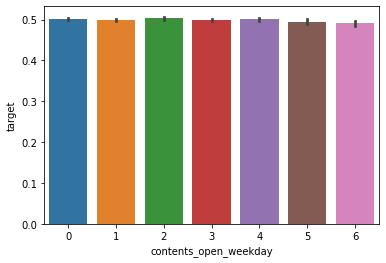

In [11]:
sns.barplot(data=train2,x='contents_open_weekday',y='target')

In [ ]:
#더미변수 처리 -> 칼럼 개수가 너무 많아질듯.
'''
train2=pd.get_dummies(train2,columns=['contents_open_weekday','contents_open_hour','person_attribute_a','person_attribute_c',
                                     'person_prefer_d_1','person_prefer_d_2','person_prefer_d_3','person_prefer_f','person_prefer_g',
                                     'person_prefer_h_1','person_prefer_h_2','person_perfer_h_3','contents_attribute_i',
                                     'contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                                     'contents_attribute_c','contents_attribute_k','contents_attribute_l','contents_attribute_d',
                                     'contents_attribute_m','contents_attribute_h'])
'''

In [9]:
#속성 매칭 여부
cols_equi = [
    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),
    ("person_prefer_d_1_s" , "contents_attribute_d_s"),
    ("person_prefer_d_2" , "contents_attribute_d"),
    ("person_prefer_d_2_n" , "contents_attribute_d_n"),
    ("person_prefer_d_2_s" , "contents_attribute_d_s"),
    ("person_prefer_d_2_m" , "contents_attribute_d_m"),
    ("person_prefer_d_2_l" , "contents_attribute_d_l"),
    ("person_prefer_d_3" , "contents_attribute_d"),
    ("person_prefer_d_3_n" , "contents_attribute_d_n"),
    ("person_prefer_d_3_s" , "contents_attribute_d_s"),
    ("person_prefer_d_3_m" , "contents_attribute_d_m"),
    ("person_prefer_d_3_l" , "contents_attribute_d_l"),
    ("person_prefer_h_2" , "contents_attribute_h"),
    ("person_prefer_h_2_l" , "contents_attribute_h_l"),
    ("person_prefer_h_2_m" , "contents_attribute_h_m"),
    ("person_prefer_h_3" , "contents_attribute_h"),
    ("person_prefer_h_3_l" , "contents_attribute_h_l"),
    ("person_prefer_h_3_m" , "contents_attribute_h_m")]

for col1, col2 in cols_equi:
       train2[f"{col1}_{col2}"] = (train2[col1] == train2[col2]).astype(int)
        
for col1, col2 in cols_equi:
       test2[f"{col1}_{col2}"] = (test2[col1] == test2[col2]).astype(int)

In [25]:
train2.iloc[:,63:]

,contents_attribute_c_person_prefer_c,contents_attribute_e_person_prefer_e,person_prefer_d_2_s_contents_attribute_d_s,person_prefer_d_2_m_contents_attribute_d_m,person_prefer_d_2_l_contents_attribute_d_l,person_prefer_d_3_s_contents_attribute_d_s,person_prefer_d_3_m_contents_attribute_d_m,person_prefer_d_3_l_contents_attribute_d_l,person_prefer_h_1_l_contents_attribute_h_l,person_prefer_h_1_m_contents_attribute_h_m,person_prefer_h_2_l_contents_attribute_h_l,person_prefer_h_2_m_contents_attribute_h_m,person_prefer_h_3_l_contents_attribute_h_l,person_prefer_h_3_m_contents_attribute_h_m
0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,1,1,1,0,1,0
2,0,0,0,1,1,0,0,0,1,0,0,0,1,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,0,0,0,0,0,0,0,0,1,0,0,0,0,0
501947,1,1,1,1,1,1,1,1,1,0,1,1,1,0
501948,1,0,0,0,1,1,1,1,1,0,0,0,0,0
501949,1,1,1,1,1,1,1,1,1,0,0,0,1,0


1    257161
0    244790
Name: contents_attribute_c_person_prefer_c, dtype: int64


<AxesSubplot:xlabel='contents_attribute_c_person_prefer_c', ylabel='count'>

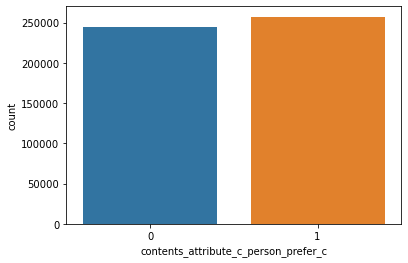

In [26]:
#회원선호속성C와 컨텐츠속성C가 일치하면 1, 불일치면 0
print(train2['contents_attribute_c_person_prefer_c'].value_counts())
sns.countplot(data=train2, x='contents_attribute_c_person_prefer_c')

0    328299
1    173652
Name: contents_attribute_e_person_prefer_e, dtype: int64


<AxesSubplot:xlabel='contents_attribute_e_person_prefer_e', ylabel='count'>

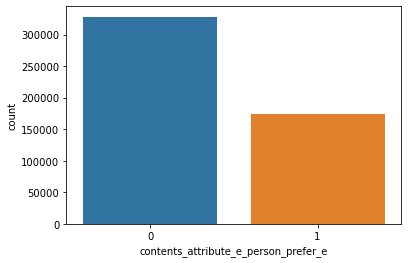

In [27]:
#회원선호속성E와 컨텐츠속성E가 일치하면 1, 불일치면 0
print(train2['contents_attribute_e_person_prefer_e'].value_counts())
sns.countplot(data=train2, x='contents_attribute_e_person_prefer_e')

In [10]:
train2.columns

Index(['id', 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_f', 'person_prefer_g',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn', 'contents_open_dt',
       'target', 'person_prefer_d_1_n', 'person_prefer_d_1_s',
       'person_prefer_d_1_m', 'person_prefer_d_1_l', 'person_prefer_d_2_n',
       'person_prefer_d_2_s', 'person_prefer_d_2_m', 'person_prefer_d_2_l',
       'person_prefer_

## 모델링 - 랜덤포레스트

In [10]:
X_train=train2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e']]
Y_train=train2.loc[:,'target']

In [11]:
X_test=test2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e']]

In [10]:
rf=RandomForestClassifier(random_state=0, n_estimators=300)

In [11]:
params= {'max_depth':[5,10,15],'min_samples_split':[5,9,13], 'max_leaf_nodes':[3,5,7],
         'max_features':['auto','sqrt','log2']}
gridcv=GridSearchCV(rf,param_grid=params,scoring ='f1',n_jobs=-1,verbose=1,cv=3)
gridcv.fit(X_train, Y_train)
print('best: ', gridcv.best_params_)
print('f1: ', gridcv.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
best:  {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 3, 'min_samples_split': 5}
f1:  0.6026859870466741


In [18]:
rf=RandomForestClassifier(random_state=0, n_estimators=500,max_depth=5, max_features='auto',max_leaf_nodes=3, min_samples_split=5)
rf.fit(X_train,Y_train)
rf_pred=rf.predict(X_test)

In [19]:
submission['target']=rf_pred
submission.to_csv('result_randomforest.csv', index=False)

## 모델링 - 랜덤포레스트2

In [10]:
X_train=train2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e','person_prefer_d_2_s_contents_attribute_d_s',
                    'person_prefer_d_2_m_contents_attribute_d_m','person_prefer_d_2_l_contents_attribute_d_l','person_prefer_d_3_s_contents_attribute_d_s',
                    'person_prefer_d_3_m_contents_attribute_d_m','person_prefer_d_3_l_contents_attribute_d_l','person_prefer_h_2_l_contents_attribute_h_l',
                    'person_prefer_h_2_m_contents_attribute_h_m','person_prefer_h_3_l_contents_attribute_h_l','person_prefer_h_3_m_contents_attribute_h_m']]
Y_train=train2.loc[:,'target']

In [11]:
X_test=test2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e','person_prefer_d_2_s_contents_attribute_d_s',
                    'person_prefer_d_2_m_contents_attribute_d_m','person_prefer_d_2_l_contents_attribute_d_l','person_prefer_d_3_s_contents_attribute_d_s',
                    'person_prefer_d_3_m_contents_attribute_d_m','person_prefer_d_3_l_contents_attribute_d_l','person_prefer_h_2_l_contents_attribute_h_l',
                    'person_prefer_h_2_m_contents_attribute_h_m','person_prefer_h_3_l_contents_attribute_h_l','person_prefer_h_3_m_contents_attribute_h_m']]

In [12]:
rf=RandomForestClassifier(random_state=0, n_estimators=300)

In [13]:
params= {'max_depth':[5,10,15],'min_samples_split':[5,9,13], 'max_leaf_nodes':[3,5,7],
         'max_features':['auto','sqrt','log2']}
gridcv=GridSearchCV(rf,param_grid=params,scoring ='f1',n_jobs=-1,verbose=1,cv=3)
gridcv.fit(X_train, Y_train)
print('best: ', gridcv.best_params_)
print('f1: ', gridcv.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
best:  {'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 7, 'min_samples_split': 5}
f1:  0.6171708347662004


In [22]:
rf=RandomForestClassifier(random_state=0, n_estimators=500,max_depth=5, max_features='auto',max_leaf_nodes=3, min_samples_split=5)
rf.fit(X_train,Y_train)
rf_pred=rf.predict(X_test)

In [23]:
threshold=0.4
rf_proba=rf.predict_proba(X_test)[:,1]
rf_pred2=np.where(rf_proba>=threshold,1,0)

In [24]:
submission['target']=rf_pred2
submission.to_csv('result_randomforest2.csv', index=False)

## 모델링 - Catboost1

In [11]:
X_train=train2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e']]
Y_train=train2.loc[:,'target']

In [12]:
X_test=test2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e']]

In [12]:
cat=CatBoostClassifier(random_state=0)

In [13]:
params= {'iterations':[500],'depth':[4,5,6]}
gridcv=GridSearchCV(cat,param_grid=params,scoring ='f1',n_jobs=-1,verbose=1,cv=3)
gridcv.fit(X_train, Y_train, cat_features=X_train.columns[X_train.nunique() > 2].tolist())
print('best: ', gridcv.best_params_)
print('f1: ', gridcv.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Learning rate set to 0.276797
0:	learn: 0.6825896	total: 950ms	remaining: 7m 53s
1:	learn: 0.6760406	total: 1.8s	remaining: 7m 29s
2:	learn: 0.6698028	total: 2.87s	remaining: 7m 55s
3:	learn: 0.6651935	total: 3.7s	remaining: 7m 39s
4:	learn: 0.6626454	total: 4.63s	remaining: 7m 38s
5:	learn: 0.6604325	total: 5.57s	remaining: 7m 38s
6:	learn: 0.6574901	total: 6.44s	remaining: 7m 33s
7:	learn: 0.6556279	total: 7.49s	remaining: 7m 40s
8:	learn: 0.6544003	total: 8.33s	remaining: 7m 34s
9:	learn: 0.6519268	total: 9.4s	remaining: 7m 40s
10:	learn: 0.6512057	total: 10.1s	remaining: 7m 31s
11:	learn: 0.6506014	total: 10.9s	remaining: 7m 23s
12:	learn: 0.6488307	total: 11.8s	remaining: 7m 20s
13:	learn: 0.6481115	total: 12.6s	remaining: 7m 17s
14:	learn: 0.6462549	total: 13.7s	remaining: 7m 22s
15:	learn: 0.6446957	total: 14.6s	remaining: 7m 23s
16:	learn: 0.6443915	total: 15.4s	remaining: 7m 16s
17:	learn: 0.6440468	total: 16.1s	remain

155:	learn: 0.6220958	total: 2m 26s	remaining: 5m 22s
156:	learn: 0.6220535	total: 2m 27s	remaining: 5m 21s
157:	learn: 0.6220012	total: 2m 28s	remaining: 5m 20s
158:	learn: 0.6219691	total: 2m 29s	remaining: 5m 19s
159:	learn: 0.6218871	total: 2m 29s	remaining: 5m 18s
160:	learn: 0.6218626	total: 2m 30s	remaining: 5m 17s
161:	learn: 0.6218274	total: 2m 31s	remaining: 5m 16s
162:	learn: 0.6217908	total: 2m 32s	remaining: 5m 14s
163:	learn: 0.6217515	total: 2m 33s	remaining: 5m 13s
164:	learn: 0.6217018	total: 2m 34s	remaining: 5m 12s
165:	learn: 0.6216767	total: 2m 34s	remaining: 5m 11s
166:	learn: 0.6216549	total: 2m 35s	remaining: 5m 10s
167:	learn: 0.6216292	total: 2m 36s	remaining: 5m 9s
168:	learn: 0.6216060	total: 2m 37s	remaining: 5m 8s
169:	learn: 0.6215888	total: 2m 38s	remaining: 5m 6s
170:	learn: 0.6215631	total: 2m 38s	remaining: 5m 5s
171:	learn: 0.6215101	total: 2m 39s	remaining: 5m 4s
172:	learn: 0.6214804	total: 2m 40s	remaining: 5m 3s
173:	learn: 0.6214577	total: 2m 41

309:	learn: 0.6171571	total: 4m 40s	remaining: 2m 51s
310:	learn: 0.6171398	total: 4m 41s	remaining: 2m 51s
311:	learn: 0.6171308	total: 4m 42s	remaining: 2m 50s
312:	learn: 0.6171070	total: 4m 43s	remaining: 2m 49s
313:	learn: 0.6170831	total: 4m 44s	remaining: 2m 48s
314:	learn: 0.6170556	total: 4m 45s	remaining: 2m 47s
315:	learn: 0.6170252	total: 4m 46s	remaining: 2m 46s
316:	learn: 0.6170152	total: 4m 46s	remaining: 2m 45s
317:	learn: 0.6169750	total: 4m 47s	remaining: 2m 44s
318:	learn: 0.6169663	total: 4m 48s	remaining: 2m 43s
319:	learn: 0.6169552	total: 4m 49s	remaining: 2m 42s
320:	learn: 0.6169436	total: 4m 50s	remaining: 2m 41s
321:	learn: 0.6169177	total: 4m 51s	remaining: 2m 41s
322:	learn: 0.6168876	total: 4m 52s	remaining: 2m 40s
323:	learn: 0.6168778	total: 4m 53s	remaining: 2m 39s
324:	learn: 0.6168610	total: 4m 54s	remaining: 2m 38s
325:	learn: 0.6168294	total: 4m 55s	remaining: 2m 37s
326:	learn: 0.6168048	total: 4m 56s	remaining: 2m 36s
327:	learn: 0.6167752	total:

463:	learn: 0.6134673	total: 6m 58s	remaining: 32.5s
464:	learn: 0.6134606	total: 6m 59s	remaining: 31.6s
465:	learn: 0.6134503	total: 7m	remaining: 30.6s
466:	learn: 0.6134262	total: 7m 1s	remaining: 29.8s
467:	learn: 0.6134002	total: 7m 2s	remaining: 28.9s
468:	learn: 0.6133901	total: 7m 2s	remaining: 28s
469:	learn: 0.6133725	total: 7m 3s	remaining: 27.1s
470:	learn: 0.6133354	total: 7m 4s	remaining: 26.1s
471:	learn: 0.6132759	total: 7m 5s	remaining: 25.3s
472:	learn: 0.6132579	total: 7m 6s	remaining: 24.3s
473:	learn: 0.6132359	total: 7m 7s	remaining: 23.5s
474:	learn: 0.6132145	total: 7m 8s	remaining: 22.6s
475:	learn: 0.6132021	total: 7m 9s	remaining: 21.7s
476:	learn: 0.6131965	total: 7m 10s	remaining: 20.7s
477:	learn: 0.6131824	total: 7m 11s	remaining: 19.8s
478:	learn: 0.6131188	total: 7m 11s	remaining: 18.9s
479:	learn: 0.6130957	total: 7m 13s	remaining: 18s
480:	learn: 0.6130614	total: 7m 14s	remaining: 17.1s
481:	learn: 0.6130355	total: 7m 15s	remaining: 16.2s
482:	learn:

In [13]:
cat=CatBoostClassifier(random_state=0, iterations=500, depth=6)
cat.fit(X_train,Y_train,cat_features=X_train.columns[X_train.nunique() > 2].tolist())
cat_pred=cat.predict(X_test)

Learning rate set to 0.276797
0:	learn: 0.6825896	total: 878ms	remaining: 7m 18s
1:	learn: 0.6760406	total: 1.74s	remaining: 7m 13s
2:	learn: 0.6698028	total: 2.79s	remaining: 7m 42s
3:	learn: 0.6651935	total: 3.59s	remaining: 7m 24s
4:	learn: 0.6626454	total: 4.49s	remaining: 7m 24s
5:	learn: 0.6604325	total: 5.62s	remaining: 7m 42s
6:	learn: 0.6574901	total: 6.63s	remaining: 7m 46s
7:	learn: 0.6556279	total: 7.68s	remaining: 7m 52s
8:	learn: 0.6544003	total: 8.46s	remaining: 7m 41s
9:	learn: 0.6519268	total: 9.75s	remaining: 7m 57s
10:	learn: 0.6512057	total: 10.5s	remaining: 7m 45s
11:	learn: 0.6506014	total: 11.2s	remaining: 7m 36s
12:	learn: 0.6488307	total: 12.1s	remaining: 7m 33s
13:	learn: 0.6481115	total: 12.9s	remaining: 7m 27s
14:	learn: 0.6462549	total: 13.9s	remaining: 7m 30s
15:	learn: 0.6446957	total: 14.9s	remaining: 7m 29s
16:	learn: 0.6443915	total: 15.6s	remaining: 7m 22s
17:	learn: 0.6440468	total: 16.4s	remaining: 7m 18s
18:	learn: 0.6434200	total: 17.2s	remaining:

156:	learn: 0.6220535	total: 2m 35s	remaining: 5m 40s
157:	learn: 0.6220012	total: 2m 36s	remaining: 5m 38s
158:	learn: 0.6219691	total: 2m 37s	remaining: 5m 38s
159:	learn: 0.6218871	total: 2m 38s	remaining: 5m 36s
160:	learn: 0.6218626	total: 2m 39s	remaining: 5m 35s
161:	learn: 0.6218274	total: 2m 40s	remaining: 5m 34s
162:	learn: 0.6217908	total: 2m 40s	remaining: 5m 32s
163:	learn: 0.6217515	total: 2m 42s	remaining: 5m 31s
164:	learn: 0.6217018	total: 2m 42s	remaining: 5m 30s
165:	learn: 0.6216767	total: 2m 43s	remaining: 5m 29s
166:	learn: 0.6216549	total: 2m 44s	remaining: 5m 28s
167:	learn: 0.6216292	total: 2m 45s	remaining: 5m 27s
168:	learn: 0.6216060	total: 2m 46s	remaining: 5m 26s
169:	learn: 0.6215888	total: 2m 47s	remaining: 5m 24s
170:	learn: 0.6215631	total: 2m 48s	remaining: 5m 23s
171:	learn: 0.6215101	total: 2m 49s	remaining: 5m 22s
172:	learn: 0.6214804	total: 2m 49s	remaining: 5m 21s
173:	learn: 0.6214577	total: 2m 50s	remaining: 5m 20s
174:	learn: 0.6214296	total:

309:	learn: 0.6171571	total: 5m 2s	remaining: 3m 5s
310:	learn: 0.6171398	total: 5m 4s	remaining: 3m 4s
311:	learn: 0.6171308	total: 5m 5s	remaining: 3m 3s
312:	learn: 0.6171070	total: 5m 6s	remaining: 3m 2s
313:	learn: 0.6170831	total: 5m 7s	remaining: 3m 1s
314:	learn: 0.6170556	total: 5m 8s	remaining: 3m 1s
315:	learn: 0.6170252	total: 5m 9s	remaining: 3m
316:	learn: 0.6170152	total: 5m 10s	remaining: 2m 58s
317:	learn: 0.6169750	total: 5m 11s	remaining: 2m 58s
318:	learn: 0.6169663	total: 5m 12s	remaining: 2m 57s
319:	learn: 0.6169552	total: 5m 13s	remaining: 2m 56s
320:	learn: 0.6169436	total: 5m 14s	remaining: 2m 55s
321:	learn: 0.6169177	total: 5m 14s	remaining: 2m 54s
322:	learn: 0.6168876	total: 5m 16s	remaining: 2m 53s
323:	learn: 0.6168778	total: 5m 17s	remaining: 2m 52s
324:	learn: 0.6168610	total: 5m 18s	remaining: 2m 51s
325:	learn: 0.6168294	total: 5m 19s	remaining: 2m 50s
326:	learn: 0.6168048	total: 5m 20s	remaining: 2m 49s
327:	learn: 0.6167752	total: 5m 20s	remaining

463:	learn: 0.6134673	total: 7m 33s	remaining: 35.2s
464:	learn: 0.6134606	total: 7m 34s	remaining: 34.2s
465:	learn: 0.6134503	total: 7m 35s	remaining: 33.2s
466:	learn: 0.6134262	total: 7m 36s	remaining: 32.2s
467:	learn: 0.6134002	total: 7m 37s	remaining: 31.3s
468:	learn: 0.6133901	total: 7m 38s	remaining: 30.3s
469:	learn: 0.6133725	total: 7m 39s	remaining: 29.3s
470:	learn: 0.6133354	total: 7m 40s	remaining: 28.3s
471:	learn: 0.6132759	total: 7m 41s	remaining: 27.4s
472:	learn: 0.6132579	total: 7m 42s	remaining: 26.4s
473:	learn: 0.6132359	total: 7m 43s	remaining: 25.4s
474:	learn: 0.6132145	total: 7m 44s	remaining: 24.5s
475:	learn: 0.6132021	total: 7m 45s	remaining: 23.5s
476:	learn: 0.6131965	total: 7m 46s	remaining: 22.5s
477:	learn: 0.6131824	total: 7m 47s	remaining: 21.5s
478:	learn: 0.6131188	total: 7m 48s	remaining: 20.5s
479:	learn: 0.6130957	total: 7m 49s	remaining: 19.6s
480:	learn: 0.6130614	total: 7m 50s	remaining: 18.6s
481:	learn: 0.6130355	total: 7m 52s	remaining:

In [16]:
submission['target']=cat_pred
submission.to_csv('result_catboost1.csv', index=False)

## 모델링 - Catboost2

In [14]:
X_train=train2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e','person_prefer_d_2_s_contents_attribute_d_s',
                    'person_prefer_d_2_m_contents_attribute_d_m','person_prefer_d_2_l_contents_attribute_d_l','person_prefer_d_3_s_contents_attribute_d_s',
                    'person_prefer_d_3_m_contents_attribute_d_m','person_prefer_d_3_l_contents_attribute_d_l','person_prefer_h_2_l_contents_attribute_h_l',
                    'person_prefer_h_2_m_contents_attribute_h_m','person_prefer_h_3_l_contents_attribute_h_l','person_prefer_h_3_m_contents_attribute_h_m']]
Y_train=train2.loc[:,'target']

In [15]:
X_test=test2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e','person_prefer_d_2_s_contents_attribute_d_s',
                    'person_prefer_d_2_m_contents_attribute_d_m','person_prefer_d_2_l_contents_attribute_d_l','person_prefer_d_3_s_contents_attribute_d_s',
                    'person_prefer_d_3_m_contents_attribute_d_m','person_prefer_d_3_l_contents_attribute_d_l','person_prefer_h_2_l_contents_attribute_h_l',
                    'person_prefer_h_2_m_contents_attribute_h_m','person_prefer_h_3_l_contents_attribute_h_l','person_prefer_h_3_m_contents_attribute_h_m']]

In [12]:
cat=CatBoostClassifier(random_state=0)

In [13]:
params= {'iterations':[500],'depth':[4,5,6]}
gridcv=GridSearchCV(cat,param_grid=params,scoring ='f1',n_jobs=-1,verbose=1,cv=3)
gridcv.fit(X_train, Y_train, cat_features=X_train.columns[X_train.nunique() > 2].tolist())
print('best: ', gridcv.best_params_)
print('f1: ', gridcv.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Learning rate set to 0.276797
0:	learn: 0.6822723	total: 980ms	remaining: 8m 9s
1:	learn: 0.6748376	total: 1.78s	remaining: 7m 23s
2:	learn: 0.6676622	total: 2.55s	remaining: 7m 3s
3:	learn: 0.6627820	total: 3.7s	remaining: 7m 38s
4:	learn: 0.6596479	total: 4.58s	remaining: 7m 33s
5:	learn: 0.6561584	total: 5.61s	remaining: 7m 41s
6:	learn: 0.6532549	total: 6.88s	remaining: 8m 4s
7:	learn: 0.6512996	total: 7.83s	remaining: 8m 1s
8:	learn: 0.6499454	total: 8.7s	remaining: 7m 54s
9:	learn: 0.6473994	total: 9.58s	remaining: 7m 49s
10:	learn: 0.6451503	total: 10.4s	remaining: 7m 42s
11:	learn: 0.6439084	total: 11.5s	remaining: 7m 48s
12:	learn: 0.6430758	total: 12.2s	remaining: 7m 35s
13:	learn: 0.6422637	total: 12.9s	remaining: 7m 29s
14:	learn: 0.6413904	total: 13.7s	remaining: 7m 22s
15:	learn: 0.6408299	total: 14.5s	remaining: 7m 19s
16:	learn: 0.6403629	total: 15.5s	remaining: 7m 19s
17:	learn: 0.6399652	total: 16.4s	remaining

155:	learn: 0.6188182	total: 2m 22s	remaining: 5m 13s
156:	learn: 0.6188008	total: 2m 22s	remaining: 5m 12s
157:	learn: 0.6187660	total: 2m 23s	remaining: 5m 10s
158:	learn: 0.6187264	total: 2m 24s	remaining: 5m 10s
159:	learn: 0.6187041	total: 2m 25s	remaining: 5m 8s
160:	learn: 0.6186309	total: 2m 26s	remaining: 5m 9s
161:	learn: 0.6185680	total: 2m 27s	remaining: 5m 8s
162:	learn: 0.6185428	total: 2m 28s	remaining: 5m 7s
163:	learn: 0.6185338	total: 2m 29s	remaining: 5m 5s
164:	learn: 0.6184756	total: 2m 29s	remaining: 5m 4s
165:	learn: 0.6184433	total: 2m 31s	remaining: 5m 4s
166:	learn: 0.6183692	total: 2m 32s	remaining: 5m 3s
167:	learn: 0.6183243	total: 2m 33s	remaining: 5m 2s
168:	learn: 0.6182933	total: 2m 34s	remaining: 5m 2s
169:	learn: 0.6182600	total: 2m 35s	remaining: 5m 1s
170:	learn: 0.6182408	total: 2m 35s	remaining: 4m 59s
171:	learn: 0.6182236	total: 2m 36s	remaining: 4m 58s
172:	learn: 0.6181684	total: 2m 37s	remaining: 4m 57s
173:	learn: 0.6181414	total: 2m 38s	rem

309:	learn: 0.6140050	total: 4m 40s	remaining: 2m 51s
310:	learn: 0.6139527	total: 4m 41s	remaining: 2m 50s
311:	learn: 0.6139388	total: 4m 41s	remaining: 2m 49s
312:	learn: 0.6139124	total: 4m 43s	remaining: 2m 49s
313:	learn: 0.6138961	total: 4m 44s	remaining: 2m 48s
314:	learn: 0.6138781	total: 4m 45s	remaining: 2m 47s
315:	learn: 0.6138638	total: 4m 45s	remaining: 2m 46s
316:	learn: 0.6138374	total: 4m 46s	remaining: 2m 45s
317:	learn: 0.6138171	total: 4m 47s	remaining: 2m 44s
318:	learn: 0.6138053	total: 4m 48s	remaining: 2m 43s
319:	learn: 0.6137692	total: 4m 49s	remaining: 2m 42s
320:	learn: 0.6136888	total: 4m 50s	remaining: 2m 41s
321:	learn: 0.6136669	total: 4m 51s	remaining: 2m 40s
322:	learn: 0.6136315	total: 4m 52s	remaining: 2m 40s
323:	learn: 0.6136215	total: 4m 53s	remaining: 2m 39s
324:	learn: 0.6135972	total: 4m 53s	remaining: 2m 38s
325:	learn: 0.6135728	total: 4m 54s	remaining: 2m 37s
326:	learn: 0.6135400	total: 4m 55s	remaining: 2m 36s
327:	learn: 0.6134884	total:

463:	learn: 0.6104009	total: 6m 57s	remaining: 32.4s
464:	learn: 0.6103804	total: 6m 57s	remaining: 31.4s
465:	learn: 0.6103637	total: 6m 58s	remaining: 30.5s
466:	learn: 0.6103412	total: 6m 59s	remaining: 29.6s
467:	learn: 0.6103172	total: 7m	remaining: 28.7s
468:	learn: 0.6102721	total: 7m 1s	remaining: 27.8s
469:	learn: 0.6102583	total: 7m 2s	remaining: 26.9s
470:	learn: 0.6102433	total: 7m 3s	remaining: 26s
471:	learn: 0.6102102	total: 7m 3s	remaining: 25.1s
472:	learn: 0.6101894	total: 7m 5s	remaining: 24.3s
473:	learn: 0.6101439	total: 7m 6s	remaining: 23.4s
474:	learn: 0.6101277	total: 7m 7s	remaining: 22.5s
475:	learn: 0.6101210	total: 7m 7s	remaining: 21.6s
476:	learn: 0.6100979	total: 7m 8s	remaining: 20.7s
477:	learn: 0.6100801	total: 7m 9s	remaining: 19.8s
478:	learn: 0.6100631	total: 7m 10s	remaining: 18.9s
479:	learn: 0.6100467	total: 7m 11s	remaining: 18s
480:	learn: 0.6100095	total: 7m 12s	remaining: 17.1s
481:	learn: 0.6099857	total: 7m 13s	remaining: 16.2s
482:	learn:

In [16]:
cat=CatBoostClassifier(random_state=0, iterations=500, depth=6)
cat.fit(X_train,Y_train,cat_features=X_train.columns[X_train.nunique() > 2].tolist())
cat_pred=cat.predict(X_test)

Learning rate set to 0.276797
0:	learn: 0.6822723	total: 815ms	remaining: 6m 46s
1:	learn: 0.6748376	total: 1.53s	remaining: 6m 22s
2:	learn: 0.6676622	total: 2.25s	remaining: 6m 12s
3:	learn: 0.6627820	total: 3.5s	remaining: 7m 13s
4:	learn: 0.6596479	total: 4.48s	remaining: 7m 24s
5:	learn: 0.6561584	total: 5.38s	remaining: 7m 22s
6:	learn: 0.6532549	total: 6.44s	remaining: 7m 33s
7:	learn: 0.6512996	total: 7.29s	remaining: 7m 28s
8:	learn: 0.6499454	total: 7.98s	remaining: 7m 15s
9:	learn: 0.6473994	total: 8.85s	remaining: 7m 13s
10:	learn: 0.6451503	total: 9.62s	remaining: 7m 7s
11:	learn: 0.6439084	total: 10.8s	remaining: 7m 18s
12:	learn: 0.6430758	total: 11.4s	remaining: 7m 8s
13:	learn: 0.6422637	total: 12.1s	remaining: 7m
14:	learn: 0.6413904	total: 12.8s	remaining: 6m 53s
15:	learn: 0.6408299	total: 13.5s	remaining: 6m 48s
16:	learn: 0.6403629	total: 14.3s	remaining: 6m 45s
17:	learn: 0.6399652	total: 14.9s	remaining: 6m 40s
18:	learn: 0.6392224	total: 16s	remaining: 6m 46s
1

156:	learn: 0.6188008	total: 2m 31s	remaining: 5m 30s
157:	learn: 0.6187660	total: 2m 32s	remaining: 5m 29s
158:	learn: 0.6187264	total: 2m 33s	remaining: 5m 28s
159:	learn: 0.6187041	total: 2m 33s	remaining: 5m 27s
160:	learn: 0.6186309	total: 2m 35s	remaining: 5m 27s
161:	learn: 0.6185680	total: 2m 36s	remaining: 5m 26s
162:	learn: 0.6185428	total: 2m 37s	remaining: 5m 25s
163:	learn: 0.6185338	total: 2m 38s	remaining: 5m 23s
164:	learn: 0.6184756	total: 2m 38s	remaining: 5m 22s
165:	learn: 0.6184433	total: 2m 39s	remaining: 5m 21s
166:	learn: 0.6183692	total: 2m 41s	remaining: 5m 21s
167:	learn: 0.6183243	total: 2m 42s	remaining: 5m 20s
168:	learn: 0.6182933	total: 2m 43s	remaining: 5m 19s
169:	learn: 0.6182600	total: 2m 44s	remaining: 5m 18s
170:	learn: 0.6182408	total: 2m 44s	remaining: 5m 17s
171:	learn: 0.6182236	total: 2m 45s	remaining: 5m 16s
172:	learn: 0.6181684	total: 2m 46s	remaining: 5m 14s
173:	learn: 0.6181414	total: 2m 47s	remaining: 5m 13s
174:	learn: 0.6181129	total:

309:	learn: 0.6140050	total: 4m 51s	remaining: 2m 58s
310:	learn: 0.6139527	total: 4m 52s	remaining: 2m 57s
311:	learn: 0.6139388	total: 4m 53s	remaining: 2m 56s
312:	learn: 0.6139124	total: 4m 54s	remaining: 2m 55s
313:	learn: 0.6138961	total: 4m 55s	remaining: 2m 54s
314:	learn: 0.6138781	total: 4m 56s	remaining: 2m 54s
315:	learn: 0.6138638	total: 4m 57s	remaining: 2m 53s
316:	learn: 0.6138374	total: 4m 58s	remaining: 2m 52s
317:	learn: 0.6138171	total: 4m 58s	remaining: 2m 51s
318:	learn: 0.6138053	total: 4m 59s	remaining: 2m 50s
319:	learn: 0.6137692	total: 5m	remaining: 2m 49s
320:	learn: 0.6136888	total: 5m 1s	remaining: 2m 48s
321:	learn: 0.6136669	total: 5m 2s	remaining: 2m 47s
322:	learn: 0.6136315	total: 5m 3s	remaining: 2m 46s
323:	learn: 0.6136215	total: 5m 4s	remaining: 2m 45s
324:	learn: 0.6135972	total: 5m 5s	remaining: 2m 44s
325:	learn: 0.6135728	total: 5m 6s	remaining: 2m 43s
326:	learn: 0.6135400	total: 5m 7s	remaining: 2m 42s
327:	learn: 0.6134884	total: 5m 8s	rema

463:	learn: 0.6104009	total: 7m 13s	remaining: 33.6s
464:	learn: 0.6103804	total: 7m 14s	remaining: 32.7s
465:	learn: 0.6103637	total: 7m 15s	remaining: 31.8s
466:	learn: 0.6103412	total: 7m 16s	remaining: 30.9s
467:	learn: 0.6103172	total: 7m 17s	remaining: 29.9s
468:	learn: 0.6102721	total: 7m 18s	remaining: 29s
469:	learn: 0.6102583	total: 7m 19s	remaining: 28.1s
470:	learn: 0.6102433	total: 7m 20s	remaining: 27.1s
471:	learn: 0.6102102	total: 7m 21s	remaining: 26.2s
472:	learn: 0.6101894	total: 7m 22s	remaining: 25.3s
473:	learn: 0.6101439	total: 7m 24s	remaining: 24.4s
474:	learn: 0.6101277	total: 7m 25s	remaining: 23.4s
475:	learn: 0.6101210	total: 7m 25s	remaining: 22.5s
476:	learn: 0.6100979	total: 7m 26s	remaining: 21.5s
477:	learn: 0.6100801	total: 7m 27s	remaining: 20.6s
478:	learn: 0.6100631	total: 7m 28s	remaining: 19.7s
479:	learn: 0.6100467	total: 7m 29s	remaining: 18.7s
480:	learn: 0.6100095	total: 7m 30s	remaining: 17.8s
481:	learn: 0.6099857	total: 7m 31s	remaining: 1

In [15]:
submission['target']=cat_pred
submission.to_csv('result_catboost2.csv', index=False)

In [17]:
threshold=0.4
cat_proba=cat.predict_proba(X_test)[:,1]
cat_pred2=np.where(cat_proba>=threshold,1,0)

In [18]:
submission['target']=cat_pred2
submission.to_csv('result_catboost2_1.csv', index=False)

## 모델링 - catboost3

In [11]:
X_train=train2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e','person_prefer_d_2_s_contents_attribute_d_s',
                    'person_prefer_d_2_m_contents_attribute_d_m','person_prefer_d_2_l_contents_attribute_d_l','person_prefer_d_3_s_contents_attribute_d_s',
                    'person_prefer_d_3_m_contents_attribute_d_m','person_prefer_d_3_l_contents_attribute_d_l','person_prefer_h_2_l_contents_attribute_h_l',
                    'person_prefer_h_2_m_contents_attribute_h_m','person_prefer_h_3_l_contents_attribute_h_l','person_prefer_h_3_m_contents_attribute_h_m',
                    'person_prefer_d_1_s_contents_attribute_d_s','person_prefer_d_2_contents_attribute_d','person_prefer_d_2_n_contents_attribute_d_n',
                    'person_prefer_d_3_contents_attribute_d','person_prefer_d_3_n_contents_attribute_d_n','person_prefer_h_2_contents_attribute_h',
                    'person_prefer_h_3_contents_attribute_h']]
Y_train=train2.loc[:,'target']

In [12]:
X_test=test2.loc[:,['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn','h_s_match_yn','person_attribute_a',
                    'person_attribute_a_1','person_attribute_b','person_prefer_c','person_prefer_d_1','person_prefer_d_2',
                    'person_prefer_d_3','person_prefer_e','person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
                    'contents_attribute_i','contents_attribute_a','contents_attribute_j_1','contents_attribute_j','contents_attribute_c',
                    'contents_attribute_k','contents_attribute_l','contents_attribute_h','contents_open_hour','contents_open_weekday',
                    'contents_attribute_c_person_prefer_c','contents_attribute_e_person_prefer_e','person_prefer_d_2_s_contents_attribute_d_s',
                    'person_prefer_d_2_m_contents_attribute_d_m','person_prefer_d_2_l_contents_attribute_d_l','person_prefer_d_3_s_contents_attribute_d_s',
                    'person_prefer_d_3_m_contents_attribute_d_m','person_prefer_d_3_l_contents_attribute_d_l','person_prefer_h_2_l_contents_attribute_h_l',
                    'person_prefer_h_2_m_contents_attribute_h_m','person_prefer_h_3_l_contents_attribute_h_l','person_prefer_h_3_m_contents_attribute_h_m',
                    'person_prefer_d_1_s_contents_attribute_d_s','person_prefer_d_2_contents_attribute_d','person_prefer_d_2_n_contents_attribute_d_n',
                    'person_prefer_d_3_contents_attribute_d','person_prefer_d_3_n_contents_attribute_d_n','person_prefer_h_2_contents_attribute_h',
                    'person_prefer_h_3_contents_attribute_h']]

In [16]:
cat=CatBoostClassifier(random_state=0)
params= {'iterations':[100],'depth':[4,5,6]}
gridcv=GridSearchCV(cat,param_grid=params,scoring ='f1',n_jobs=-1,verbose=1,cv=3)
gridcv.fit(X_train, Y_train, cat_features=X_train.columns[X_train.nunique() > 2].tolist())
print('best: ', gridcv.best_params_)
print('f1: ', gridcv.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Learning rate set to 0.5
0:	learn: 0.6769243	total: 288ms	remaining: 28.5s
1:	learn: 0.6713150	total: 524ms	remaining: 25.7s
2:	learn: 0.6687155	total: 751ms	remaining: 24.3s
3:	learn: 0.6658270	total: 1.01s	remaining: 24.2s
4:	learn: 0.6636258	total: 1.19s	remaining: 22.6s
5:	learn: 0.6620428	total: 1.38s	remaining: 21.6s
6:	learn: 0.6608985	total: 1.55s	remaining: 20.6s
7:	learn: 0.6597465	total: 1.71s	remaining: 19.6s
8:	learn: 0.6590939	total: 1.87s	remaining: 18.9s
9:	learn: 0.6582394	total: 2.04s	remaining: 18.3s
10:	learn: 0.6575085	total: 2.23s	remaining: 18s
11:	learn: 0.6569346	total: 2.41s	remaining: 17.7s
12:	learn: 0.6563429	total: 2.58s	remaining: 17.3s
13:	learn: 0.6558668	total: 2.75s	remaining: 16.9s
14:	learn: 0.6555667	total: 2.92s	remaining: 16.6s
15:	learn: 0.6553194	total: 3.09s	remaining: 16.2s
16:	learn: 0.6551064	total: 3.27s	remaining: 16s
17:	learn: 0.6546115	total: 3.45s	remaining: 15.7s
18:	learn: 0

In [17]:
cat=CatBoostClassifier(random_state=0, iterations=500, depth=5)
cat.fit(X_train,Y_train,cat_features=X_train.columns[X_train.nunique() > 2].tolist())
cat_pred=cat.predict(X_test)

Learning rate set to 0.276797
0:	learn: 0.6827459	total: 666ms	remaining: 5m 32s
1:	learn: 0.6761362	total: 1.4s	remaining: 5m 49s
2:	learn: 0.6719280	total: 2s	remaining: 5m 30s
3:	learn: 0.6669479	total: 2.64s	remaining: 5m 27s
4:	learn: 0.6643148	total: 3.27s	remaining: 5m 23s
5:	learn: 0.6607863	total: 4.17s	remaining: 5m 43s
6:	learn: 0.6575588	total: 5.05s	remaining: 5m 55s
7:	learn: 0.6564172	total: 5.7s	remaining: 5m 50s
8:	learn: 0.6536758	total: 6.57s	remaining: 5m 58s
9:	learn: 0.6516145	total: 7.34s	remaining: 5m 59s
10:	learn: 0.6502353	total: 8.12s	remaining: 6m
11:	learn: 0.6493044	total: 8.62s	remaining: 5m 50s
12:	learn: 0.6477683	total: 9.51s	remaining: 5m 56s
13:	learn: 0.6472409	total: 10s	remaining: 5m 48s
14:	learn: 0.6465645	total: 10.6s	remaining: 5m 41s
15:	learn: 0.6460876	total: 11.1s	remaining: 5m 36s
16:	learn: 0.6440838	total: 12s	remaining: 5m 40s
17:	learn: 0.6429517	total: 12.8s	remaining: 5m 42s
18:	learn: 0.6420978	total: 13.6s	remaining: 5m 44s
19:	l

156:	learn: 0.6218873	total: 1m 51s	remaining: 4m 2s
157:	learn: 0.6218580	total: 1m 51s	remaining: 4m 1s
158:	learn: 0.6218201	total: 1m 52s	remaining: 4m
159:	learn: 0.6217731	total: 1m 52s	remaining: 3m 59s
160:	learn: 0.6217342	total: 1m 53s	remaining: 3m 58s
161:	learn: 0.6217114	total: 1m 54s	remaining: 3m 58s
162:	learn: 0.6217013	total: 1m 54s	remaining: 3m 57s
163:	learn: 0.6216604	total: 1m 55s	remaining: 3m 56s
164:	learn: 0.6216538	total: 1m 55s	remaining: 3m 55s
165:	learn: 0.6216289	total: 1m 56s	remaining: 3m 54s
166:	learn: 0.6215954	total: 1m 57s	remaining: 3m 54s
167:	learn: 0.6215664	total: 1m 58s	remaining: 3m 53s
168:	learn: 0.6215434	total: 1m 58s	remaining: 3m 52s
169:	learn: 0.6215340	total: 1m 59s	remaining: 3m 51s
170:	learn: 0.6214827	total: 2m	remaining: 3m 50s
171:	learn: 0.6214648	total: 2m	remaining: 3m 49s
172:	learn: 0.6214542	total: 2m 1s	remaining: 3m 48s
173:	learn: 0.6214188	total: 2m 1s	remaining: 3m 48s
174:	learn: 0.6213708	total: 2m 2s	remaining

309:	learn: 0.6180521	total: 3m 35s	remaining: 2m 12s
310:	learn: 0.6180321	total: 3m 36s	remaining: 2m 11s
311:	learn: 0.6180168	total: 3m 36s	remaining: 2m 10s
312:	learn: 0.6180109	total: 3m 37s	remaining: 2m 9s
313:	learn: 0.6179916	total: 3m 38s	remaining: 2m 9s
314:	learn: 0.6179684	total: 3m 38s	remaining: 2m 8s
315:	learn: 0.6179490	total: 3m 39s	remaining: 2m 7s
316:	learn: 0.6179356	total: 3m 40s	remaining: 2m 7s
317:	learn: 0.6179079	total: 3m 40s	remaining: 2m 6s
318:	learn: 0.6178994	total: 3m 41s	remaining: 2m 5s
319:	learn: 0.6178545	total: 3m 41s	remaining: 2m 4s
320:	learn: 0.6178471	total: 3m 42s	remaining: 2m 4s
321:	learn: 0.6178237	total: 3m 43s	remaining: 2m 3s
322:	learn: 0.6178149	total: 3m 43s	remaining: 2m 2s
323:	learn: 0.6177805	total: 3m 44s	remaining: 2m 1s
324:	learn: 0.6177560	total: 3m 45s	remaining: 2m 1s
325:	learn: 0.6177420	total: 3m 45s	remaining: 2m
326:	learn: 0.6177053	total: 3m 46s	remaining: 1m 59s
327:	learn: 0.6176976	total: 3m 47s	remaining

464:	learn: 0.6155072	total: 5m 19s	remaining: 24s
465:	learn: 0.6154933	total: 5m 19s	remaining: 23.3s
466:	learn: 0.6154894	total: 5m 20s	remaining: 22.6s
467:	learn: 0.6154821	total: 5m 20s	remaining: 21.9s
468:	learn: 0.6154662	total: 5m 21s	remaining: 21.2s
469:	learn: 0.6154346	total: 5m 22s	remaining: 20.6s
470:	learn: 0.6154194	total: 5m 22s	remaining: 19.9s
471:	learn: 0.6154084	total: 5m 23s	remaining: 19.2s
472:	learn: 0.6153917	total: 5m 24s	remaining: 18.5s
473:	learn: 0.6153651	total: 5m 24s	remaining: 17.8s
474:	learn: 0.6153469	total: 5m 25s	remaining: 17.1s
475:	learn: 0.6153359	total: 5m 26s	remaining: 16.4s
476:	learn: 0.6153318	total: 5m 27s	remaining: 15.8s
477:	learn: 0.6153120	total: 5m 27s	remaining: 15.1s
478:	learn: 0.6152905	total: 5m 28s	remaining: 14.4s
479:	learn: 0.6152708	total: 5m 28s	remaining: 13.7s
480:	learn: 0.6152554	total: 5m 29s	remaining: 13s
481:	learn: 0.6152292	total: 5m 30s	remaining: 12.3s
482:	learn: 0.6152196	total: 5m 30s	remaining: 11.

In [20]:
threshold=0.3
cat_proba=cat.predict_proba(X_test)[:,1]
cat_pred2=np.where(cat_proba>=threshold,1,0)

In [21]:
submission['target']=cat_pred2
submission.to_csv('result_catboost3_2.csv', index=False)